In [54]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

<a name='1-1'></a>
### 1.1 - Load the Data and Split the Data into Train/Test Sets

You'll be using the Happy House dataset for this part of the assignment, which contains images of peoples' faces. Your task will be to build a ConvNet that determines whether the people in the images are smiling or not -- because they only get to enter the house if they're smiling!  

In [55]:

def load_happy_dataset():
    train_dataset = h5py.File('./dataset/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./dataset/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [56]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


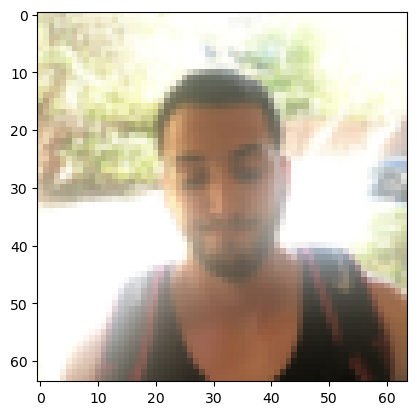

In [57]:
index = 124
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

Create the Sequential Model

The TensorFlow Keras Sequential API can be used to build simple models with layer operations that proceed in a sequential order. 

You can also add layers incrementally to a Sequential model with the `.add()` method, or remove them using the `.pop()` method, much like you would in a regular Python list.

Actually, you can think of a Sequential model as behaving like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters.  If your model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice!

For any layer construction in Keras, you'll need to specify the input shape in advance. This is because in Keras, the shape of the weights is based on the shape of the inputs. The weights are only created when the model first sees some input data. Sequential models can be created by passing a list of layers to the Sequential constructor, like you will do in the next assignment.


Implement the `happyModel` function below to build the following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Take help from [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 

Also, plug in the following parameters for all the steps:

 - [ZeroPadding2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D): padding 3, input shape 64 x 64 x 3
 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 32 7x7 filters, stride 1
 - [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): for axis 3
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Using default parameters
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 1 neuron and a sigmoid activation. 


In [58]:
# GRADED FUNCTION: happyModel

def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
        
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
#             tf.keras.layers.ZeroPadding2D(padding=3),
            tf.keras.layers.ZeroPadding2D(padding=(3,3),input_shape=(64, 64, 3), data_format="channels_last"),

            ## Conv2D with 32 7x7 filters and stride of 1
            tf.keras.layers.Conv2D(32,(7,7),strides=(1, 1)),

            ## BatchNormalization for axis 3
            tf.keras.layers.BatchNormalization(axis=3),

            ## ReLU
            tf.keras.layers.ReLU(),

            ## Max Pooling 2D with default parameters
            tf.keras.layers.MaxPooling2D(),
        
            ## Flatten layer
            tf.keras.layers.Flatten(),

            ## Dense layer with 1 unit for output & 'sigmoid' activation
            tf.keras.layers.Dense(1, activation='sigmoid')

        ])
    
    return model

In [59]:
happy_model = happyModel()

In [78]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [79]:
happy_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_3 (ZeroPaddi  (None, 70, 70, 3)        0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                      

<a name='3-2'></a>
### 3.2 - Train and Evaluate the Model

After creating the model, compiling it with your choice of optimizer and loss function, and doing a sanity check on its contents, you are now ready to build! 

Simply call `.fit()` to train. That's it! No need for mini-batching, saving, or complex backpropagation computations. That's all been done for you, as you're using a TensorFlow dataset with the batches specified already. You do have the option to specify epoch number or minibatch size if you like (for example, in the case of an un-batched dataset).

In [82]:
history = happy_model.fit(X_train, Y_train, epochs=10, batch_size=16, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/10
15/15 [==============================] - 5s 210ms/step - loss: 0.0277 - accuracy: 0.9937 - val_loss: 0.0565 - val_accuracy: 0.9833
Epoch 2/10
15/15 [==============================] - 3s 201ms/step - loss: 0.0166 - accuracy: 0.9937 - val_loss: 0.0388 - val_accuracy: 0.9917
Epoch 3/10
15/15 [==============================] - 3s 206ms/step - loss: 0.0138 - accuracy: 0.9937 - val_loss: 0.0290 - val_accuracy: 0.9917
Epoch 4/10
15/15 [==============================] - 3s 209ms/step - loss: 0.0143 - accuracy: 0.9979 - val_loss: 0.0171 - val_accuracy: 0.9917
Epoch 5/10
15/15 [==============================] - 3s 224ms/step - loss: 0.0182 - accuracy: 0.9958 - val_loss: 0.0553 - val_accuracy: 0.9833
Epoch 6/10
15/15 [==============================] - 3s 225ms/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.0405 - val_accuracy: 0.9917
Epoch 7/10
15/15 [==============================] - 3s 226ms/step - loss: 0.0498 - accuracy: 0.9833 - val_loss: 0.0428 - val_accuracy: 0.9917
Epoch 

In [83]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 68ms/step - loss: 0.0720 - accuracy: 0.9667


[0.07195461541414261, 0.9666666388511658]

In [84]:
y_pred = happy_model.predict(X_test)

5/5 [==============================] - 0s 52ms/step


In [85]:
y_ = [1 if x >= 0.75 else 0 for x in y_pred]

In [86]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.98      0.96      0.97        84

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

